## Big data analytics: Big Data Bowl 
Authored by Jason Maloney and Jesse Pezzillo

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# This dataset can be downloaded from https://www.kaggle.com/c/nfl-big-data-bowl-2020/data after an agreement is digitally signed through kaggle. 
data = pd.read_csv('train.csv')
#lower all columns
data.columns = map(str.lower, data.columns)

#### Exploritory Data Analysis and cleaning

In [3]:
print(data.dtypes)
# preview a few records
data.head()

gameid                      int64
playid                      int64
team                       object
x                         float64
y                         float64
s                         float64
a                         float64
dis                       float64
orientation               float64
dir                       float64
nflid                       int64
displayname                object
jerseynumber                int64
season                      int64
yardline                    int64
quarter                     int64
gameclock                  object
possessionteam             object
down                        int64
distance                    int64
fieldposition              object
homescorebeforeplay         int64
visitorscorebeforeplay      int64
nflidrusher                 int64
offenseformation           object
offensepersonnel           object
defendersinthebox         float64
defensepersonnel           object
playdirection              object
timehandoff   

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [4]:
# get count of records per year
print(data['season'].value_counts())
# get count of recors per offence formation
print(data['offenseformation'].value_counts())

2017    261800
2018    247962
2019    172392
Name: season, dtype: int64
SINGLEBACK    299728
SHOTGUN       206558
I_FORM        136950
PISTOL         21538
JUMBO          14894
WILDCAT         1694
EMPTY            682
ACE               22
Name: offenseformation, dtype: int64


In [5]:
# create function to convert playerHeight to inches
def heightToInches(x):
    try:
        x,x1 = x.split('-')
        x = int(x)
        x1 = int(x1)
        x = (12*x) + x1
        return(x)
    except:
        return int(x*12)

In [6]:
# run function over column
data["playerheight"] = data["playerheight"].map(heightToInches)

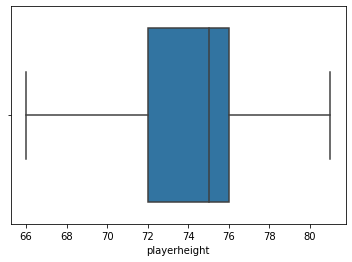

In [7]:
# visualize height distribution
sns.boxplot(data["playerheight"])

In [16]:
# convert TimeHandoff to dates and times
data['timehandoff'] = pd.to_datetime(data['timehandoff'])
data['timesnap'] = pd.to_datetime(data['timesnap'])
# confirm dtype
print('handoff time:',data["timehandoff"].dtype)
print('snap time:',data["timesnap"].dtype)

handoff time: datetime64[ns, UTC]
snap time: datetime64[ns, UTC]


In [41]:
# convert windspeed
def windConvert(x):
    try:
        x = re.match('[0-9]+',x)
        return(x)
    except:
        return(x)
data["windspeed"] = data["windspeed"].map(windConvert)

TypeError: unhashable type: 'list'

In [111]:
# create a rusher dummy variable
rusher = []
for i in range(len(subset)):
    if subset['NflId'][i] == subset['NflIdRusher'][i]:
        rusher.append(1)
    else:
        rusher.append(0)

In [112]:
subset['Rusher'] = rusher

In [113]:
subset.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Rusher
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0


In [76]:
# find euclidean distance (yds) of players to rusher
# calculate the distance of each player to rusher - come back to this
# make a location variable an ordered pair I think that would make this loop work
# need to group this by the play
from scipy.spatial import distance
# need p1 and p2 - p1 = rusher, p2 = everyone else
for i in range(len(subset[:35])):
    if subset['Rusher'][i] == 1:
        p1 = (subset['X'][i], subset['Y'][i])
    
    print(distance.euclidean(p1, p2))

NameError: name 'p1' is not defined

In [99]:
# separate the personnel offense and defense
#set(subset['OffensePersonnel'])
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"0 0 OL0 OL1 RB, 1 TE, 3 WR 1 ...",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"0 0 0 OL0 OL0 OL1 RB, 1 TE, 3 ...",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"0 0 0 OL0 OL0 OL1 RB, 1 TE, 3 ...",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"0 0 0 OL0 OL0 OL1 RB, 1 TE, 3 ...",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"0 0 0 OL0 OL0 OL1 RB, 1 TE, 3 ...",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [132]:
# split at the comma - OL RB TE WR
oi = []
for i in range(len(subset)):
    op = subset['OffensePersonnel'][i]
    if 'OL' not in op:
        newofper = '0 OL, ' + op
    else:
        newofper = subset['OffensePersonnel'][i]
    oi.append(newofper)
oi


['0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 '0 OL, 1 RB, 1 TE, 3 WR',
 

In [133]:
# find the count of each position
# convert to int
# store
ol = []
rb = []
te = []
wr = []
for pers in oi:
    # this finds the numbers - all personnel in the same order OL RB TE WR 
    # stores the number as a string
    val = re.findall('\d', pers)
    # convert to an int and store
    ol.append(int(val[0]))
    rb.append(int(val[1]))
    te.append(int(val[2]))
    wr.append(int(val[3]))

# in the future - values of 0 OL = 11 - (sum(wr,rb,te)+1(qb))

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [138]:
# do the same for defense
# what are the positions?
#set(subset['DefensePersonnel'])
# no missing values, so just need to get the digits
# order is DL LB DB
#dl = []
#lb = []
#db = []
#for pers in subset['DefensePersonnel']:
#   val = re.findall('\d', pers)
#    # dl = val[0], lb = val[1], db = val[2]
#    dl.append(int(val[0]))
#    lb.append(int(val[1]))
#    db.append(int(val[2]))

2.944